<a href="https://colab.research.google.com/github/SUYAMBULAKSHMI-VENKATESAN/DAMAKA/blob/main/Segmentation_Watershed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

+--------------------+--------------------+----------------+-------------+------------+
| Stage              | Method             | Params         | Mean        | Std Dev    |
+====================+====================+================+=============+============+
| Blurred Image      | (5, 5)             | -              | Mean=98.23  | Std=29.66  |
+--------------------+--------------------+----------------+-------------+------------+
| Thresholded (Otsu) | -                  | -              | Mean=158.60 | Std=123.65 |
+--------------------+--------------------+----------------+-------------+------------+
| Sure Background    | Dilation           | Kernel=3x3     | Mean=168.81 | Std=120.62 |
+--------------------+--------------------+----------------+-------------+------------+
| Sure Foreground    | Distance Transform | Thresh=0.7*max | Mean=7.67   | Std=43.56  |
+--------------------+--------------------+----------------+-------------+------------+
| Final Watershed    |          

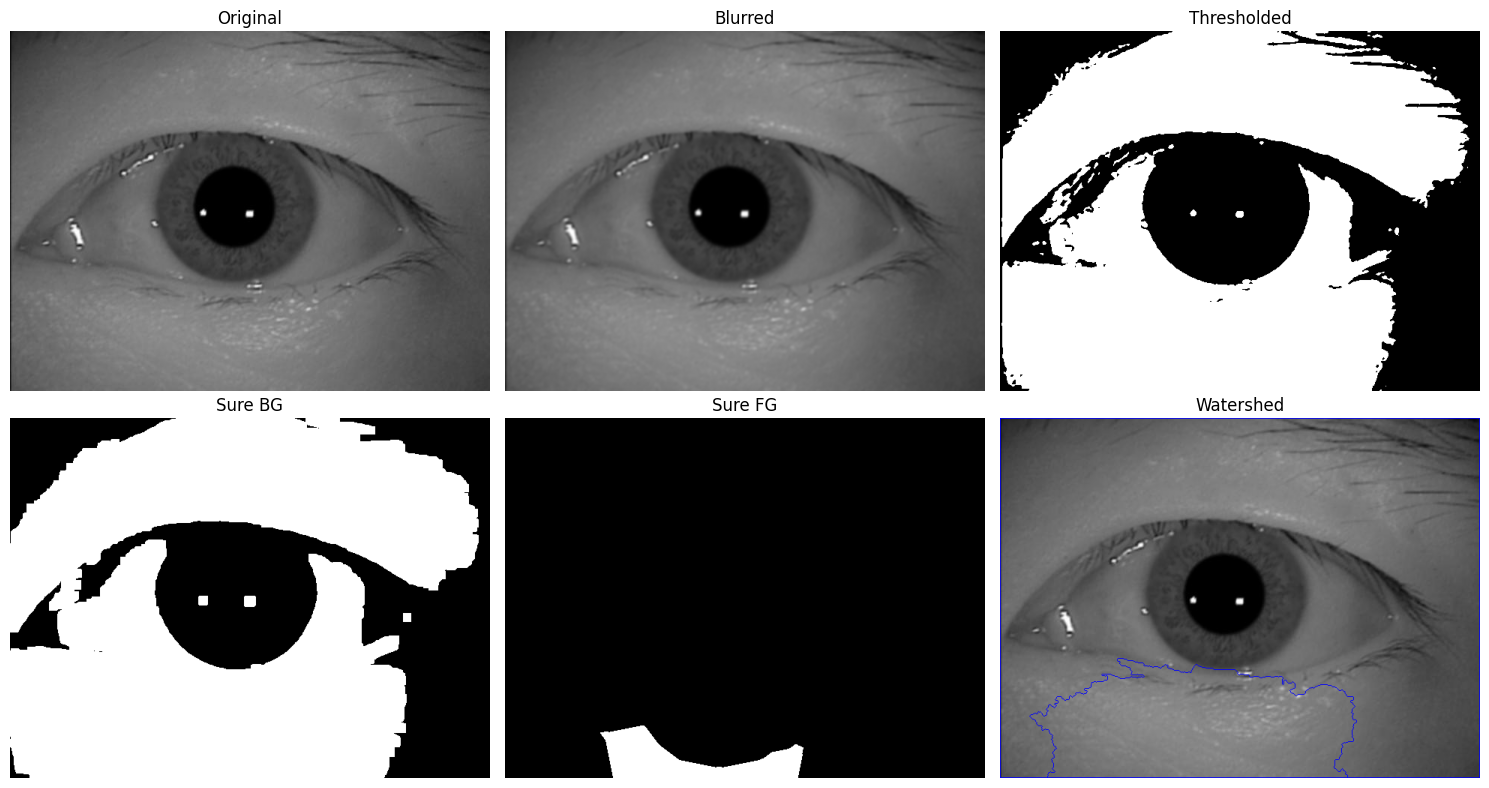

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

def apply_watershed_segmentation(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")

    original = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Preprocessing - Gaussian Blur
    blur_kernel_size = (5, 5)
    blurred = cv2.GaussianBlur(gray, blur_kernel_size, 0)

    # Apply Otsu thresholding
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Noise removal using morphological operations
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0
    markers = markers + 1

    # Mark the unknown region with zero
    markers[unknown == 255] = 0

    # Apply watershed
    markers = cv2.watershed(image, markers)
    image[markers == -1] = [255, 0, 0]  # Boundary marked in red

    # Metrics
    table_data = [
        ["Blurred Image", str(blur_kernel_size), "-", f"Mean={np.mean(blurred):.2f}", f"Std={np.std(blurred):.2f}"],
        ["Thresholded (Otsu)", "-", "-", f"Mean={np.mean(thresh):.2f}", f"Std={np.std(thresh):.2f}"],
        ["Sure Background", "Dilation", "Kernel=3x3", f"Mean={np.mean(sure_bg):.2f}", f"Std={np.std(sure_bg):.2f}"],
        ["Sure Foreground", "Distance Transform", "Thresh=0.7*max", f"Mean={np.mean(sure_fg):.2f}", f"Std={np.std(sure_fg):.2f}"],
        ["Final Watershed", "", "", f"Mean={np.mean(image):.2f}", f"Std={np.std(image):.2f}"],
    ]

    headers = ["Stage", "Method", "Params", "Mean", "Std Dev"]
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

    # Show images
    titles = ["Original", "Blurred", "Thresholded", "Sure BG", "Sure FG", "Watershed"]
    images = [original, blurred, thresh, sure_bg, sure_fg, image]

    plt.figure(figsize=(15, 8))
    for i in range(len(images)):
        plt.subplot(2, 3, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB) if images[i].ndim == 3 else images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    return table_data

# Example usage:
result = apply_watershed_segmentation("/content/S6000S00.jpg")